# Initial Imports

In [ ]:
# Initial imports
import networkx as nx
import matplotlib.pyplot as plt
import random
from random import shuffle
import math
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_fluidc
from sklearn.metrics import *

# Loading the network

In [ ]:
# Loading the network
observed = nx.read_gml('./cond-mat.gml', label="id")
observed = nx.Graph(observed, name="Observed Links")

random.seed(1000)

probe_size = int(0.3 * (observed.number_of_edges()))
probe_edge_set = random.sample(list(observed.edges()), probe_size)

training = nx.Graph(observed, name="Training Links")
for i in probe_edge_set:
    training.remove_edge(i[0], i[1])

print(nx.info(observed), "\n")
print(nx.info(training), "\n")
print("Probe Edge Set\nNumber of edges:", len(probe_edge_set))

Name: Observed Links
Type: Graph
Number of nodes: 16706
Number of edges: 121251
Average degree:  14.5159 

Name: Training Links
Type: Graph
Number of nodes: 16706
Number of edges: 84876
Average degree:  10.1611 

Probe Edge Set
Number of edges: 36375


# CLP-ID


In [ ]:
graph = observed
nodes=graph.nodes()
mapNodes={}
i=0
for j in nodes:
	mapNodes[i]=j
	i+=1

N=graph.number_of_nodes()
# N=1000


# print(graph.get_edge_data(mapNodes[1084],mapNodes[0],default=0))
weightedGraph=[]
listedGraph=[]
# nx.draw(graph)
for i in range(N):
	weightNodes=[]
	listedNode=[]
	totWeight=0
	for j in range(N):
		# print(graph.get_edge_data(mapNodes[0],mapNodes[1],default=0)['value'])
		weight=graph.get_edge_data(mapNodes[i],mapNodes[j],default=0)
		if(weight!=0):
			try:
				weight=weight['value']
			except KeyError:
				weight=1
			totWeight+=weight
	for j in range(N):
		# print(graph.get_edge_data(mapNodes[0],mapNodes[1],default=0)['value'])
		weight=graph.get_edge_data(mapNodes[i],mapNodes[j],default=0)
		if(weight!=0):
			try:
				weight=weight['value']
			except KeyError:
				weight=1
			weightNodes.append([j,weight])
			weight=weight/totWeight
			listedNode.append([j,weight])

	listedGraph.append(listedNode)
	weightedGraph.append(weightNodes)
# print(listedGraph)

def detachabilityIndex(listedGraph,N,communityOfNode):
	dIndex=[0]*N
	totDIndex=[0]*N
	for x in range(N):
		for edge in listedGraph[x]:
			if(communityOfNode[x]==communityOfNode[edge[0]]):
				dIndex[communityOfNode[x]]+=edge[1]
			totDIndex[communityOfNode[x]]+=edge[1]
	for x in range(N):
		if(dIndex[x]!=0):
			dIndex[x]/=totDIndex[x]
	# print(dIndex)
	return dIndex

def findDetachabitlity(Ci,Cz,listedGraph,N,communityOfNode,nodesOfCommunity):
	nodes=set()
	for node in nodesOfCommunity[Ci]:
		nodes.add(node)
	for node in nodesOfCommunity[Cz]:
		nodes.add(node)
	numerator=0
	denomentor=0
	for node in nodes:
		for edge in listedGraph[node]:
			if(communityOfNode[edge[0]]==Ci or communityOfNode[edge[0]]==Cz):
				numerator+=edge[1]
			denomentor+=edge[1]
	if(numerator==0):
		return 0
	return numerator/denomentor



def combine(listedGraph,N,dIndex,communityOfNode,thresoldDetachability):
	nodesOfCommunity=[]
	# print(nodesOfCommunity)
	for x in range(N):
		nodesOfCommunity.append([])
	for x in range(N):
		# print(communityOfNode[x],x)
		nodesOfCommunity[communityOfNode[x]].append(x)
	# print(nodesOfCommunity)
	for Ci in range(N):
		# print(Ci)
		if(dIndex[Ci]==0 or dIndex[Ci]>=thresoldDetachability):
			continue
		# print(nodesOfCommunity[Ci])
		neighboursWithCount={}
		maxi=0
		for node in nodesOfCommunity[Ci]:
			for edge in listedGraph[node]:
				if(communityOfNode[edge[0]]!=communityOfNode[node]):
					count=0
					if(edge[0] in neighboursWithCount):
						count=neighboursWithCount[edge[0]]
					neighboursWithCount[edge[0]]=1+count
					maxi=max(maxi,1+count)
		communityWithMaxi=set()
		# print(neighboursWithCount,maxi)
		for node in neighboursWithCount.keys():
			if(neighboursWithCount[node]==maxi):
				communityWithMaxi.add(communityOfNode[node])
		# print(communityWithMaxi)
		newDetachability=-10000000
		newCommunity=Ci
		for Cz in communityWithMaxi:
			combineDetachability=findDetachabitlity(Ci,Cz,listedGraph,N,communityOfNode,nodesOfCommunity)
			if(combineDetachability>newDetachability):
				newDetachability=combineDetachability
				newCommunity=Cz
		for node in nodesOfCommunity[Ci]:
			communityOfNode[node]=newCommunity
			# print(Ci,newCommunity,node)
			nodesOfCommunity[newCommunity].append(node)
		nodesOfCommunity[Ci]=[]
		dIndex[Ci]=0
		dIndex[newCommunity]=newDetachability
	# print(communityOfNode)
	# print(dIndex)
	return communityOfNode,nodesOfCommunity

def partition(listedGraph,N,Iterations):
	communityOfNode=[]
	for i in range(N):
		communityOfNode.append(i)
	while(Iterations>0):
		Iterations-=1
		temCommunity=communityOfNode
		for x in range(N):
			agrmaxOfNode=[1]*N
			mini=1
			miniAtCommunity=x
			for edge in listedGraph[x]:
				agrmaxOfNode[communityOfNode[edge[0]]]*=(1-edge[1])
				if(agrmaxOfNode[communityOfNode[edge[0]]]<mini):
					mini=agrmaxOfNode[communityOfNode[edge[0]]]
					miniAtCommunity=communityOfNode[edge[0]]
			temCommunity[x]=miniAtCommunity
			# communityOfNode[x]=miniAtCommunity
		communityOfNode=temCommunity
	# print(communityOfNode)
	return communityOfNode

nodesOfCommunity=[]
communityOfNode=[]

noOfIterations=10

# thresoldDetachability=1

communityOfNode=partition(listedGraph,N,noOfIterations)
dIndex=detachabilityIndex(listedGraph,N,communityOfNode)
def findCommunity(thresoldDetachability):
	global communityOfNode,nodesOfCommunity
	communityOfNode,nodesOfCommunity=combine(listedGraph,N,dIndex,communityOfNode,thresoldDetachability)
	ans=[]
	for x in nodesOfCommunity:
		if(len(x)>0):
			ans.append(x)
	return ans

# print(communityOfNode)
ans = findCommunity(1)
print("No. of communities",len(ans))
# for i in ans:
#     print(i)

No. of communities 1188


# Get community labels

In [ ]:
# Get the community partition
community_list_gmc=list(ans) # This is for CLP-ID
# This is for GMC
# community_list_gmc=list(greedy_modularity_communities(training))

# community_list_gmc=list(asyn_lpa_communities(training))
# community_list_gmc=list(label_propagation_communities(training))
# community_list_gmc=list(asyn_fluidc(training,N/100))

# Store community label for each node
community_labels={}
for i in range(len(community_list_gmc)):
    for j in community_list_gmc[i]:
        community_labels[j]=i+1

# Store nodes contained in each community
total_number_of_communities = len(community_list_gmc)
total_number_of_nodes = len(training)
nodes_in_community={}
for i in range(1,total_number_of_communities+1):
    nodes_in_community[i]=[]
for i in range(0,total_number_of_nodes):
    nodes_in_community[community_labels[i]].append(i)

# Number of edges contained inside a particular community
edges_in_community = {}
edges_from_to_community = {}
for i in range(1,total_number_of_communities+1):
  edges_in_community[i]=0
for link in list(observed.edges):
    st = link[0]
    en = link[1]
    if community_labels[st]==community_labels[en]:
        if community_labels[st] in edges_in_community:
            edges_in_community[community_labels[st]]+=1
    else:
        com_x = community_labels[st]
        com_y = community_labels[en]

        if (com_x,com_y) in edges_from_to_community or (com_y,com_x) in edges_from_to_community:
            edges_from_to_community[(com_x,com_y)]+=1
            edges_from_to_community[(com_y,com_x)]+=1
        else:
            edges_from_to_community[(com_x,com_y)]=1
            edges_from_to_community[(com_y,com_x)]=1

#Debug Output
print("Total Number of nodes:",total_number_of_nodes)
print("Total Number of communities:",total_number_of_communities)
print(60*"=")
print("Nodes in community")
print(nodes_in_community)
print(60*"=")
print("edges_in_community")
print(edges_in_community)
print(60*"=")
print("edges_from_to_community")
print(edges_from_to_community)
print(60*"=")

Total Number of nodes: 16726
Total Number of communities: 1188
Nodes in community
{1: [9], 2: [28], 3: [33], 4: [99], 5: [142], 6: [160], 7: [184, 185], 8: [223, 224, 225], 9: [242], 10: [265], 11: [281], 12: [284, 285, 11679, 11680], 13: [304, 305, 306], 14: [320, 321], 15: [323, 324, 325], 16: [373, 374, 375, 910, 911, 1535, 1536, 2448, 2449, 2910, 14182, 15890], 17: [403], 18: [420, 421, 422], 19: [444, 445], 20: [537], 21: [547], 22: [570], 23: [585, 586, 587, 588, 589], 24: [592], 25: [626], 26: [633], 27: [666], 28: [702, 703], 29: [717, 718], 30: [749], 31: [796], 32: [849], 33: [922, 923, 924, 925, 13162, 13163, 13164], 34: [950, 951, 10099, 10100, 15917, 16667], 35: [980, 981, 1683], 36: [1042, 1043, 1044, 14962], 37: [1092, 1093, 1094, 1095, 1120, 3105, 6619], 38: [1196], 39: [1201], 40: [1210, 1211], 41: [1212, 1213], 42: [1214], 43: [1, 2, 1236], 44: [1240, 1241, 1242, 13448], 45: [1247, 1248, 6521, 7599, 7600], 46: [1250], 47: [490, 491, 1347], 48: [1361], 49: [1370, 1371]

# Helper functions for ICCM

In [ ]:
# Calculate internal collaboration score for ICCM
def collaboration_score(G, u, v):
    neighbours_u = list(G[u])
    neighbours_v = list(G[v])
    community_both = community_labels[u]
    nodes_in_this_community = nodes_in_community[community_both]

    common_neighbours = np.intersect1d(neighbours_u,neighbours_v)
    numr = len(np.intersect1d(common_neighbours,nodes_in_this_community))

    all_neighbours = np.union1d(neighbours_u,neighbours_v)
    denmr = len(np.intersect1d(all_neighbours,nodes_in_this_community))

    internal_cs = 0
    if denmr!=0:
        internal_cs = numr/denmr
    
    nodes_outside_this_community = np.setdiff1d(list(G.nodes),nodes_in_this_community)
    numr2 = len(np.intersect1d(common_neighbours,nodes_outside_this_community))
    denmr2 = len(np.intersect1d(all_neighbours,nodes_outside_this_community))
    
    external_cs = 0
    if denmr!=0:
        external_cs = numr/denmr

    external_cs = external_cs ** 0.5

    return (internal_cs*external_cs)

# Calculate degree of interconnection
def degree_of_interconnection(com_1, com_2):
    numr = 0
    if (com_1,com_2) in edges_from_to_community:
        numr = edges_from_to_community[(com_1,com_2)]
    
    denmr = edges_in_community[com_1]+edges_in_community[com_2]
    if denmr == 0:
        return 0
    return numr/denmr

#Calculate contribution to interconnection
def contribution_to_interconnection(G, u, v):
    com_v = community_labels[v]
    com_u = community_labels[u]

    nodes_in_community_u = nodes_in_community[com_u]
    nodes_in_community_v = nodes_in_community[com_v]

    numr = len(np.intersect1d(list(G[u]),nodes_in_community_v))+len(np.intersect1d(list(G[v]),nodes_in_community_u))
    denmr = len(list(G[u]))+len(list(G[v]))

    if denmr == 0:
        return 0
    return numr/denmr

# Apply Prediction

In [ ]:
def _apply_prediction(G, f, ebunch=None):
    """Applies the given function to each edge in the specified iterable of edges.

    'G' is an instance of :class:'networkx.Graph'.

    'f' is a function on two inputs, each of which is a node in the graph.
    The function can return anything, but it should return a value
    representing a prediction of the score of a "link" joining the two nodes.

    'ebunch' is an iterable of pairs of nodes. If not specified, all non-edges in the graph 'G' will be used.
    """
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return [(u, v, f(u, v)) for u, v in ebunch]

# AUC implementation

In [ ]:
# ====================================================
# CALCULATING/PLOTTING AUC : AREA UNDER ROC CURVE
# ====================================================
def trunc_avg(data):
    avg = sum(data)/len(data)
    avg = math.trunc(avg*1000)/1000
    return avg

def AUC(score_probe, score_non_existent):
    N = min(len(score_probe), len(score_non_existent))

    n1 = n2 = n3 = 0
    for i in range(N):
        probe_edge = score_probe[i]
        non_ex_edge = score_non_existent[i]
        if probe_edge[2] > non_ex_edge[2]:
            n1 += 1
        elif probe_edge[2] < non_ex_edge[2]:
            n3 += 1
        else:
            n2 += 1

    tp = tn = n1 + n2 / 2
    fp = fn = N - tp

    AUC = 0
    if N > 0:
        AUC = tp / N
    return AUC


def plot(mins, maxs, means, vals, names):
    #     fig,(sub,box) = plt.subplots(ncols = 2, figsize = (15,5))

    fig = plt.figure(1)
    sub = fig.add_subplot(111)
    fig2 = plt.figure(2)
    box = fig2.add_subplot(111)

    tests = len(names)
    iters = 0
    if tests > 0:
        iters = len(vals[0])

    #   Line Plot
    for i in range(tests):
        name = names[i]
        l = vals[i]
        sub.plot(range(1, len(l) + 1), l, '-o', label=name)

    sub.set_title("Area Under ROC Curve")
    sub.set_xlabel('Iteration')
    sub.set_ylabel('AUC')
    sub.set_xticks(np.arange(1, iters + 1, 1.0))
    sub.set_yticks(np.arange(0, 1.1, 0.1))

    sub.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #     sub.legend(loc='center left', bbox_to_anchor=(0.5, -0.4))
    sub.axhline(0.5, linestyle='--', color='k')
    sub.yaxis.grid()

    #   Box Plot
    box.set_title("Area Under ROC Curve")
    box.set_ylabel('AUC')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(rotation=90)
    box.axis(ymin=0, ymax=1)
    box.axhline(0.5, linestyle='--', color='k')
    box.yaxis.grid()

    box.errorbar(names, means, fmt='sb', lw=3)
    box.errorbar(names, means,
                 [np.array(means) - np.array(mins), np.array(maxs) - np.array(means)],
                 fmt='.b', ecolor='blue', lw=1, capsize=3, capthick=3, ms=9, markerfacecolor='none', mew=1)
    plt.show()


def plotAUC(metrics, N=100, T=10):
    mins = []
    maxs = []
    means = []
    names = []
    vals = []
    
    for name, f in metrics.items():
        l = []
        accuracy = []
        f1 = []
        recall = []
        my_auc = []
        for i in range(T):
            pro = random.sample(probe_edge_set, N)
            score_probe = f(training, pro)
            non_e = random.sample(list(nx.non_edges(observed)), N)
            score_non_existent = f(training, non_e)
            y_actual = [1 for j in range(len(score_probe))]
            y_actual += [0 for j in range(len(score_non_existent))]
            y_score = [u[2] for u in score_probe]
            y_score += [u[2] for u in score_non_existent]
            
            y_score_labels = []
            for j in range(len(y_score)):
                y_score_labels.append([y_score[j],j])
            y_score_labels.sort()
            y_score_labels.reverse()
            y_pred = [0]*len(y_score)
            for j in range(len(y_score_labels)//2):
                y_pred[y_score_labels[j][1]]=1
            

            # y_score_sorted = y_score[:]
            # y_score_sorted.sort()
            # threshold_for_CF = y_score_sorted[-len(score_probe)]
            # threshold_for_CF = 0.85
            # y_pred = []
            # y_score2 = [u[2] for u in score_probe]
            # y_score2 += [u[2] for u in score_non_existent]
            # for tmp in y_score2:
                # if tmp>=threshold_for_CF:
                #     y_pred.append(1)
                # else:
                #     y_pred.append(0)
            # print(confusion_matrix(y_actual,y_pred))
            accuracy.append(accuracy_score(y_actual,y_pred))
            f1.append(f1_score(y_actual,y_pred))
            recall.append(recall_score(y_actual,y_pred))
            l += [AUC(score_probe, score_non_existent)]
            # print(threshold_for_CF)
            # print(y_actual)
            # print(y_score)
            # print(y_pred)
            # print(score_probe)
            # print(score_non_existent)
            # my_auc.append(roc_auc_score(y_actual,y_score))

        
        AUCrange = (min(l), max(l), trunc_avg(l))
        vals.append(l)
        mins.append(AUCrange[0])
        maxs.append(AUCrange[1])
        means.append(AUCrange[2])
        names.append(name)
        # print(name, ':', AUCrange, sum(accuracy)/len(accuracy),sum(precision)/len(precision),sum(recall)/len(recall))
        avg_accuracy = sum(accuracy)/len(accuracy)
        avg_accuracy = math.trunc(avg_accuracy*1000)/1000
        avg_f1 = sum(f1)/len(f1)
        avg_f1 = math.trunc(avg_f1*1000)/1000
        # print(name, ':', AUCrange, " | Accuracy:",avg_accuracy,"| My AUC:",sum(my_auc)/len(my_auc))
        print(name, ':', AUCrange, " | Accuracy:",avg_accuracy)
        
        # print(name, ':', AUCrange)

    plot(mins, maxs, means, vals, names)

# Similarity methods

In [ ]:
# ====================================================
# CRISP LOGIC : SIMILARITY METRICS
# ====================================================
def graph_distance(G, ebunch=None):
    """Compute the score based on shortest path length (number of nodes in the path).
    """

    def predict(u, v):
        try:
            return -nx.shortest_path_length(G, source=u, target=v)
        except:
            return -observed.number_of_nodes()

    return _apply_prediction(G, predict, ebunch)


def path_length(G, ebunch=None):
    """Compute the score based on shortest path length (sum of weights).
    """

    def predict(u, v):
        try:
            return -nx.shortest_path_length(G, source=u, target=v, weight='value')
        except:
            return -observed.number_of_nodes()

    return _apply_prediction(G, predict, ebunch)


def common_neighbors(G, ebunch=None):
    """Compute the Common Neighbours of all node pairs in ebunch.
    """

    def predict(u, v):
        return len(list(nx.common_neighbors(G, u, v)))

    return _apply_prediction(G, predict, ebunch)


def jaccard_coefficient(G, ebunch=None):
    """Compute the Jaccard coefficient of all node pairs in ebunch.
    """

    def predict(u, v):
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size

    return _apply_prediction(G, predict, ebunch)


def adamic_adar_index(G, ebunch=None):
    """Compute the Adamic-Adar index of all node pairs in ebunch.
    """

    def predict(u, v):
        # Added 1 in denominator to avoid division by zero, worked fine on GrQc_U.gml
        return sum(1 / (math.log(G.degree(w))+1) for w in nx.common_neighbors(G, u, v))

    return _apply_prediction(G, predict, ebunch)


def resource_allocation_index(G, ebunch=None):
    """Compute the resource allocation index of all node pairs in ebunch.
    """

    def predict(u, v):
        return sum(1 / G.degree(w) for w in nx.common_neighbors(G, u, v))

    return _apply_prediction(G, predict, ebunch)


def preferential_attachment(G, ebunch=None):
    """Compute the preferential attachment score of all node pairs in ebunch.
    """

    def predict(u, v):
        return G.degree(u) * G.degree(v)

    return _apply_prediction(G, predict, ebunch)


def clustering_coefficient(G, ebunch=None):
    """Compute the Clustering Coefficient score of all node pairs in ebunch.
    """

    def predict(u, v):
        return nx.clustering(G, u) + nx.clustering(G, v)

    return _apply_prediction(G, predict, ebunch)


def weighted_clustering_coefficient(G, ebunch=None):
    """Compute the Weighted Clustering Coefficient score of all node pairs in ebunch.
    """

    def predict(u, v):
        return nx.clustering(G, u, weight='value') + nx.clustering(G, v, weight='value')

    return _apply_prediction(G, predict, ebunch)

def ICCM(G, ebunch=None):
    """Compute the ICCM coefficients for eacallh pair of nodes in ebunch
    """

    def predict(u, v):
        if community_labels[u] == community_labels[v]:
            return collaboration_score(G, u, v)
        else:
            deg_ic = degree_of_interconnection(community_labels[u], community_labels[v])
            cic = contribution_to_interconnection(G, u, v)
            cic = cic ** 0.5

            union_size = len(set(G[u]) | set(G[v]))
            jaccard_coeff = 0
            if union_size != 0:
                jaccard_coeff = len(list(nx.common_neighbors(G, u, v))) / union_size

            score = deg_ic * cic
            # score = (score + jaccard_coeff)/2
            return score
    
    return _apply_prediction(G, predict, ebunch)


# Calculate and plot AUC

Graph Distance : (0.87, 0.965, 0.909)  | Accuracy: 0.859
Path Length : (0.85, 0.935, 0.886)  | Accuracy: 0.827
Common Neighbors : (0.875, 0.92, 0.897)  | Accuracy: 0.794
Jaccard Coefficient : (0.865, 0.91, 0.886)  | Accuracy: 0.773
Adamic/Adar Index : (0.875, 0.92, 0.898)  | Accuracy: 0.796
Resource Allocation Index : (0.86, 0.93, 0.888)  | Accuracy: 0.777
Preferential Attachment : (0.625, 0.815, 0.737)  | Accuracy: 0.663
Clustering Coefficient : (0.385, 0.55, 0.466)  | Accuracy: 0.454
Weighted Clustering Coefficient : (0.325, 0.495, 0.417)  | Accuracy: 0.43
ICCM : (0.865, 0.9, 0.883)  | Accuracy: 0.767


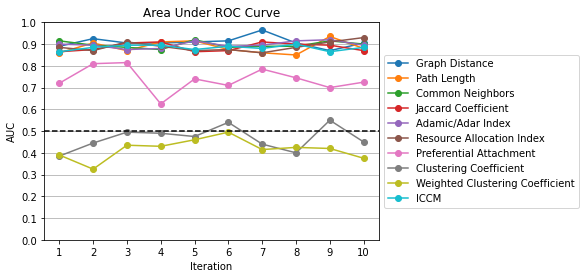

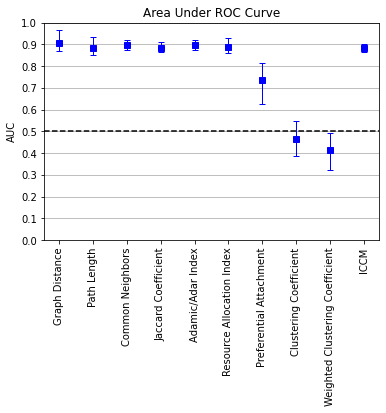

In [ ]:
metrics = {
    "Graph Distance": graph_distance,
    "Path Length": path_length,
    "Common Neighbors": common_neighbors,
    "Jaccard Coefficient": jaccard_coefficient,
    "Adamic/Adar Index": adamic_adar_index,
    "Resource Allocation Index": resource_allocation_index,
    "Preferential Attachment": preferential_attachment,
    "Clustering Coefficient": clustering_coefficient,
    "Weighted Clustering Coefficient": weighted_clustering_coefficient,
    "ICCM":ICCM,
}
plotAUC(metrics)

